# sub-n-classes, Shannon Entropy labelling, looped

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
import time
from numpy.random import *

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
def randints_nodup(k):
    ns = []
    while (len(ns) < k):
        n = randint(0, 10)
        if not n in ns:
            ns.append(n)
    return list(ns) 

In [3]:
# entropy labelling
def ent_label(probas, s_cls):
    info_con = (-1)*np.log2(probas)
    # entropy
    Hp = np.sum(np.multiply(probas, info_con))
    # クラス数変えると，probaでのindexがそのままlabelとして使えないのでs_cls内を参照させる
    labels = np.array([s_cls[i] for i, Ipk in enumerate(info_con) if Ipk <= Hp])
    
    return labels

In [4]:
# duplicating images k-1 times, for k-labels
def dup_imgs(img, labels):
    k = len(labels)
    if k == 1:
        #print(img.shape)
        return np.array(img)
    else:
        tmp_dup = np.array([img for _ in range(k)])
        #print(tmp_dup.shape)
        return tmp_dup

In [5]:
# 乱数でクラスを選ぶ
def entropy_scls_learning(classes_num, orig_A, lim_A):
    # sortされてないとpredict_probaとるときに整合性とれなくなる
    s_cls = randints_nodup(classes_num)
    # sort()は破壊的変更を行うだけで，sortされたlistそのものが返ってくるのではない
    s_cls.sort()

    # 選ばれたクラスだけのデータとラベルを用意
    trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] in s_cls]
    trn_labels = [label for label in train_labels if label in s_cls]

    tst_imgs = [img for i, img in enumerate(test_imgs) if test_labels[i] in s_cls]
    tst_labels = [label for label in test_labels if label in s_cls]

    # 2クラスの場合，選ばれたクラス次第では，というかほとんどの組み合わせでdiv by 0になってしまうらしい
    # generate an annotator
    a1_model = LR().fit(trn_imgs[:orig_A], trn_labels[:orig_A])
    a1_proba = a1_model.predict_proba(trn_imgs[orig_A:orig_A + lim_A])

    # entropy labelling
    mul_labels = [ent_label(probas, s_cls) for probas in a1_proba]
    m_labels = []

    for labels in mul_labels:
         [m_labels.append(l) for l in labels]
    
    # images duplication
    dupld_imgs = np.array([dup_imgs(img, mul_labels[i]) for i, img in enumerate(trn_imgs[orig_A:orig_A + lim_A])])

    d_imgs = []

    for img in dupld_imgs:
        a = img.shape
        n = a[0]
        if (n == img_SIZE):
            d_imgs.append(img)
        else:
            for _ in range(n):
                d_imgs.append(img[0])

    d_imgs = np.array(d_imgs)

    # final learning
    final_model = LR().fit(d_imgs, m_labels)
    acc = accuracy_score(tst_labels, final_model.predict(tst_imgs))
    
    return acc*100

#### ラベルづけからその正解率を評価まで行う関数

In [6]:
# labelling and evaluating them
def entropy_scls_eval(classes_num, orig_A, lim_A):

    # sortされてないとpredict_probaとるときに整合性とれなくなる
    s_cls = randints_nodup(classes_num)
    # sort()は破壊的変更を行うだけで，sortされたlistそのものが返ってくるのではない
    s_cls.sort()
    #print(s_cls)

    # 選ばれたクラスだけのデータとラベルを用意
    trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] in s_cls]
    trn_labels = [label for label in train_labels if label in s_cls]

    tst_imgs = [img for i, img in enumerate(test_imgs) if test_labels[i] in s_cls]
    tst_labels = [label for label in test_labels if label in s_cls]

    # 2クラスの場合，選ばれたクラス次第では，というかほとんどの組み合わせでdiv by 0になってしまうらしい
    # generate an annotator
    a1_model = LR().fit(trn_imgs[:orig_A], trn_labels[:orig_A])
    a1_proba = a1_model.predict_proba(trn_imgs[orig_A:orig_A + lim_A])

    # entropy labelling
    mul_labels = [ent_label(probas, s_cls) for probas in a1_proba]
    
    # labels score evaluation
    score = 0
    for labels, t_label in zip(mul_labels, trn_labels[orig_A:orig_A + lim_A]):
        for l in labels:
            if (l == t_label):
                score += 1

    m_labels = []
    for labels in mul_labels:
         [m_labels.append(l) for l in labels]                
                    
    return (len(m_labels)/lim_A, score*100/len(m_labels), score*100/lim_A) 

## MNIST

In [7]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_imgs = np.array([x.ravel() for x in train_images])
test_imgs = np.array([y.ravel() for y in test_images])

img_SIZE = train_images.shape[1]*train_images.shape[2]

Using TensorFlow backend.


### learning

In [10]:
orig_A1, lim_A1 = 2000, 2000
mnist_results = [np.average([entropy_scls_learning(j, orig_A1, lim_A1) for _ in range(10)]) for j in range(2, 10)]
mnist_results.append(entropy_scls_learning(10, orig_A1, lim_A1))
print(mnist_results)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/usr/local/lib/python3.7/site-package

[97.66916134833815, 96.58614482442194, 93.29499155704659, 91.59423650035593, 90.53714338421896, 87.70591761895017, 86.22185833542538, 84.37418313283771, 81.67999999999999]


### labels evalutaiton

In [8]:
orig_A1, lim_A1 = 2000, 2000
mnist_evals = []
for j in range(2, 11):
    a, b, c = 0, 0, 0
    if j == 10:
        sample_lnum, sample_lqual, sample_lqual2 = entropy_scls_eval(j, orig_A1, lim_A1)
        mnist_evals.append((sample_lnum, sample_lqual, sample_lqual2))
    else:    
        for _ in range(10):
            sample_lnum, sample_lqual, sample_lqual2 = entropy_scls_eval(j, orig_A1, lim_A1)
            a += sample_lnum
            b += sample_lqual
            c += sample_lqual2
        mnist_evals.append((a/10, b/10, c/10))
print(f"evaluation of labels genereated for mnist; (# of labels per image, labels quality [%], lebels quality as groups [%])\n{mnist_evals}")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/usr/local/lib/python3.7/site-package

evaluation of labels genereated for mnist; (# of labels per image, labels quality [%], lebels quality as groups [%])
[(0.9356500000000001, 97.59112842711961, 91.44), (1.00055, 95.09837104519026, 95.15), (1.0051999999999999, 92.11736652570067, 92.585), (1.0105, 91.63631865089286, 92.58500000000001), (1.0141499999999997, 90.18507482103416, 91.45), (1.0228, 87.52875104060001, 89.52000000000001), (1.0335999999999999, 85.03314578957648, 87.88499999999999), (1.04305, 83.77746449706856, 87.38), (1.0515, 82.1207798383262, 86.35)]


### &uarr;画像あたりの平均ラベル数が1を切る場合は，分布が確定的になりすぎてエントロピー計算でアンダーフローが発生した結果，ラベルが一つもつかない場合があると推察される

## CIFAR 10

In [10]:
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# number of data samples
train_N, test_N = train_images.shape[0], test_images.shape[0]
# data normalisation and vecotrise
train_imgs, test_imgs = train_images.reshape(train_N, -1)/255, test_images.reshape(test_N, -1)/255
# labels ravel
train_labels, test_labels = train_labels.ravel(), test_labels.ravel()

img_SIZE = train_images.shape[1]*train_images.shape[2]*train_images.shape[3]

### learning

In [ ]:
orig_A2, lim_A2 = 2000, 2000
cifar10_results = [np.average([entropy_scls_learning(j, orig_A2, lim_A2) for _ in range(10)]) for j in range(2, 10)]
cifar10_results.append(entropy_scls_learning(10, orig_A2, lim_A2))
print(cifar10_results)

### labels evalutaiton

In [8]:
orig_A2, lim_A2 = 2000, 2000
cifar10_evals = []
for j in range(2, 11):
    a, b, c = 0, 0, 0
    if j == 10:
        sample_lnum, sample_lqual, sample_lqual2 = entropy_scls_eval(j, orig_A2, lim_A2)
        cifar10_evals.append((sample_lnum, sample_lqual, sample_lqual2))
    else:    
        for _ in range(10):
            sample_lnum, sample_lqual, sample_lqual2 = entropy_scls_eval(j, orig_A2, lim_A2)
            a += sample_lnum
            b += sample_lqual
            c += sample_lqual2
        cifar10_evals.append((a/10, b/10, c/10))
print(f"evaluation of labels genereated for cifar10; (# of labels per image, labels quality [%], lebels quality as groups [%])\n{cifar10_evals}")

evaluation of labels genereated for cifar10; (# of labels per image, labels quality [%], lebels quality as groups[%])
[(1.0, 74.75, 74.75), (1.0503, 59.12454317334923, 61.989999999999995), (1.1259000000000001, 52.07008511489069, 58.395), (1.21395, 44.659508244866444, 54.17), (1.2910499999999998, 38.921387720990715, 50.225), (1.37705, 33.05457607486076, 45.485), (1.45695, 30.184617088821017, 43.97), (1.53715, 26.949681416477638, 41.42), (1.573, 25.33375715193897, 39.85)]


## CIFAR100

In [13]:
from keras.datasets import cifar100

(train_images, train_labels), (test_images, test_labels) = cifar100.load_data(label_mode = "fine")

# number of data samples
train_N, test_N = train_images.shape[0], test_images.shape[0]
# data normalisation and vecotrise
train_imgs, test_imgs = train_images.reshape(train_N, -1)/255, test_images.reshape(test_N, -1)/255
# labels ravel
train_labels, test_labels = train_labels.ravel(), test_labels.ravel()

img_SIZE = train_images.shape[1]*train_images.shape[2]*train_images.shape[3]

### learning

In [18]:
orig_A3, lim_A3 = 200, 200
cifar100_results = [np.average([entropy_scls_learning(j, orig_A3, lim_A3) for _ in range(10)]) for j in range(2, 10)]
cifar100_results.append(entropy_scls_learning(10, orig_A3, lim_A3))
print(cifar100_results)

### labels evalutaiton

In [14]:
orig_A3, lim_A3 = 200, 200
cifar100_evals = []
for j in range(2, 11):
    a, b, c = 0, 0, 0
    if j == 10:
        sample_lnum, sample_lqual, sample_lqual2 = entropy_scls_eval(j, orig_A3, lim_A3)
        cifar100_evals.append((sample_lnum, sample_lqual, sample_lqual2))
    else:    
        for _ in range(10):
            sample_lnum, sample_lqual, sample_lqual2 = entropy_scls_eval(j, orig_A3, lim_A3)
            a += sample_lnum
            b += sample_lqual
            c += sample_lqual2
        cifar100_evals.append((a/10, b/10, c/10))
print(f"evaluation of labels genereated for cifar100; (# of labels per image, labels quality [%], lebels quality as groups [%])\n{cifar100_evals}")

evaluation of labels genereated for cifar100; (# of labels per image, labels quality [%], lebels quality as groups [%])
[(1.0, 74.05, 74.05), (1.0544999999999998, 62.104241102486604, 65.35), (1.1214999999999997, 51.47451323040567, 57.7), (1.1934999999999998, 44.192441242368616, 52.65), (1.2449999999999997, 42.06936819425348, 52.25), (1.355, 32.95733722136263, 44.65), (1.4009999999999998, 30.70275968857884, 43.0), (1.4565000000000001, 26.245987142981033, 38.2), (1.505, 25.58139534883721, 38.5)]


### labels evaluationの結果 いくつかベタ打ちのを読み込んだので注意

1/Kの結果ベタ打ち

In [30]:
oneKth_mnist_evals = [(1.0, 98.535, 98.535), (1.0337999999999998, 93.474425718079, 96.59), (1.0581, 90.81419007456978, 96.01), (1.0956000000000001, 86.1299731028797, 94.28), (1.1239000000000001, 82.26485567364804, 92.39500000000001), (1.1456, 80.36772302436852, 91.985), (1.1787, 76.9199874518848, 90.645), (1.2041499999999998, 74.92200535609274, 90.2), (1.2255, 73.19461444308446, 89.7)]
oneKth_cifar10_evals = [(1.0, 74.89500000000001, 74.89500000000001), (1.2692, 55.37420648812955, 70.145), (1.49495, 45.74459316392563, 68.3), (1.6934, 39.62396687129409, 67.05499999999999), (1.9530999999999998, 32.21940547853991, 62.86), (2.1416, 28.74886685872645, 61.55), (2.3503999999999996, 25.600694800298573, 60.154999999999994), (2.5581, 22.96395128959202, 58.739999999999995), (2.712, 21.109882005899706, 57.25)]
oneKth_cifar100_evals = [(1.0, 77.2, 77.2), (1.24, 58.172364364922245, 72.0), (1.4460000000000002, 44.860119469499764, 64.75), (1.6415, 39.18608024073104, 64.2), (1.8370000000000002, 31.914771437344246, 58.5), (2.066, 28.362822089935, 58.5), (2.2589999999999995, 24.41651839267302, 55.15), (2.4054999999999995, 21.666044289564223, 52.1), (2.525, 20.594059405940595, 52.0)]

In [31]:
# Shannon Entropy
lnum_mnist = [e[0] for e in mnist_evals]
lqual_mnist = [e[1] for e in mnist_evals]
lqual2_mnist = [e[2] for e in mnist_evals]

lnum_cifar10 = [e[0] for e in cifar10_evals]
lqual_cifar10 = [e[1] for e in cifar10_evals]
lqual2_cifar10 = [e[2] for e in cifar10_evals]

lnum_cifar100 = [e[0] for e in cifar100_evals]
lqual_cifar100 = [e[1] for e in cifar100_evals]
lqual2_cifar100 = [e[2] for e in cifar100_evals]

# 1/K
lnum_mnist_oneKth = [e[0] for e in oneKth_mnist_evals]
lqual_mnist_oneKth = [e[1] for e in oneKth_mnist_evals]
lqual2_mnist_oneKth = [e[2] for e in oneKth_mnist_evals]

lnum_cifar10_oneKth = [e[0] for e in oneKth_cifar10_evals]
lqual_cifar10_oneKth = [e[1] for e in oneKth_cifar10_evals]
lqual2_cifar10_oneKth = [e[2] for e in oneKth_cifar10_evals]

lnum_cifar100_oneKth = [e[0] for e in oneKth_cifar100_evals]
lqual_cifar100_oneKth = [e[1] for e in oneKth_cifar100_evals]
lqual2_cifar100_oneKth = [e[2] for e in oneKth_cifar100_evals]

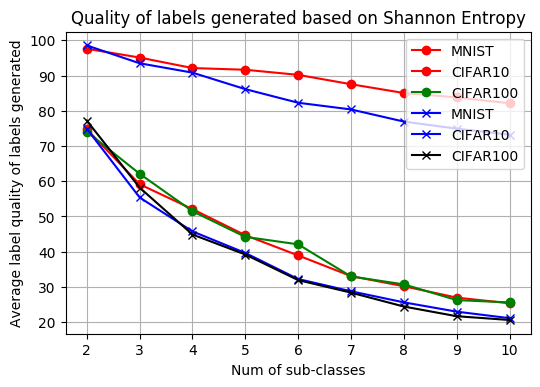

In [35]:
plt.figure(dpi = 100)
plt.title("Quality of labels generated based on Shannon Entropy")
# Shannon Entropy
plt.plot([i for i in range(2, 11)], lqual_mnist, marker = "o", color = "r", label = "MNIST")
plt.plot([i for i in range(2, 11)], lqual_cifar10, marker = "o", color = "r", label = "CIFAR10")
plt.plot([i for i in range(2, 11)], lqual_cifar100, marker = "o", color = "g", label = "CIFAR100")
# 1/K
plt.plot([i for i in range(2, 11)], lqual_mnist_oneKth, marker = "x", color = "b", label = "MNIST")
plt.plot([i for i in range(2, 11)], lqual_cifar10_oneKth, marker = "x", color = "b", label = "CIFAR10")
plt.plot([i for i in range(2, 11)], lqual_cifar100_oneKth, marker = "x", color = "k", label = "CIFAR100")

plt.xlabel("Num of sub-classes")
plt.ylabel("Average label quality of labels generated")	
plt.legend(loc = "upper right")
plt.grid(True)

念の為entropyの方もベタ打ち保存

In [ ]:
mnist_evals = [(0.9356500000000001, 97.59112842711961, 91.44), (1.00055, 95.09837104519026, 95.15), (1.0051999999999999, 92.11736652570067, 92.585), (1.0105, 91.63631865089286, 92.58500000000001), (1.0141499999999997, 90.18507482103416, 91.45), (1.0228, 87.52875104060001, 89.52000000000001), (1.0335999999999999, 85.03314578957648, 87.88499999999999), (1.04305, 83.77746449706856, 87.38), (1.0515, 82.1207798383262, 86.35)]
cifar10_evals = [(1.0, 74.75, 74.75), (1.0503, 59.12454317334923, 61.989999999999995), (1.1259000000000001, 52.07008511489069, 58.395), (1.21395, 44.659508244866444, 54.17), (1.2910499999999998, 38.921387720990715, 50.225), (1.37705, 33.05457607486076, 45.485), (1.45695, 30.184617088821017, 43.97), (1.53715, 26.949681416477638, 41.42), (1.573, 25.33375715193897, 39.85)]
cifar100_evals = [(1.0, 74.05, 74.05), (1.0544999999999998, 62.104241102486604, 65.35), (1.1214999999999997, 51.47451323040567, 57.7), (1.1934999999999998, 44.192441242368616, 52.65), (1.2449999999999997, 42.06936819425348, 52.25), (1.355, 32.95733722136263, 44.65), (1.4009999999999998, 30.70275968857884, 43.0), (1.4565000000000001, 26.245987142981033, 38.2), (1.505, 25.58139534883721, 38.5)]

## 結果 ベタ打ちだから消すと後悔するぞ

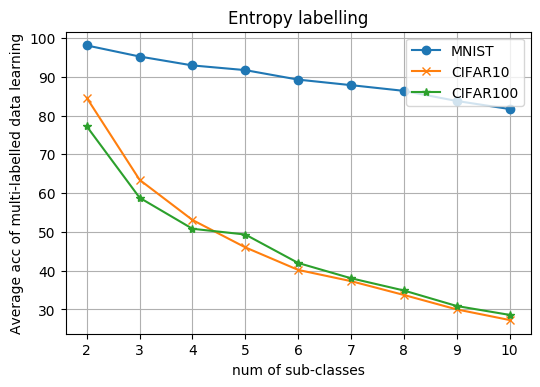

In [19]:
plt.figure(dpi = 100)
plt.title("Entropy labelling")
plt.plot([i for i in range(2, 11)], results, marker = "o", label = "MNIST")
plt.plot([i for i in range(2, 11)], results2, marker = "x", label = "CIFAR10")
plt.plot([i for i in range(2, 11)], results3, marker = "*", label = "CIFAR100")
plt.xlabel("Num of sub-classes")
plt.ylabel("Average acc of multi-labelled data learning")	
plt.legend(loc = "upper right")
plt.grid(True)

In [20]:
print(f"MNIST (10回の平均)\n{results}")
print(f"CIFAR10 (遅いので3回の平均)\n{results2}")
print(f"CIFAR100 (10回の平均)\n{results3}")

MNIST (10回の平均)
[98.07248227 95.21826069 92.92167649 91.71057297 89.26130571 87.83640245
 86.3645797  83.75733294 81.68      ]
CIFAR10 (遅いので3回の平均)
[84.55       63.41111111 53.06666667 46.00666667 40.19444444 37.3
 33.7375     30.01481481 27.28      ]
CIFAR100 (10回の平均)
[77.2        58.8        50.8        49.32       41.98333333 38.04285714
 34.8875     30.88888889 28.6       ]


In [27]:
ent_results = [results, results2, results3]

### アノテータモデルによるラベルで学習した結果

entropyの結果

In [ ]:
[array([98.07248227, 95.21826069, 92.92167649, 91.71057297, 89.26130571,
        87.83640245, 86.3645797 , 83.75733294, 81.68      ]),
 array([84.55      , 63.41111111, 53.06666667, 46.00666667, 40.19444444,
        37.3       , 33.7375    , 30.01481481, 27.28      ]),
 array([77.2       , 58.8       , 50.8       , 49.32      , 41.98333333,
        38.04285714, 34.8875    , 30.88888889, 28.6       ])]

1/Kの結果

In [30]:
oneKth_results = [[97.36281997, 94.74324793, 92.88411133, 89.52189082, 87.0354047 ,
        86.5668632 , 83.15581019, 80.56001975, 79.87      ],
[75.58333333, 61.57777778, 57.625     , 46.96      , 42.65      ,
        35.83333333, 33.05416667, 29.24814815, 27.19      ],
[73.        , 62.8       , 54.        , 48.82      , 43.06666667,
        38.28571429, 34.7375    , 31.28888889, 27.4       ]]

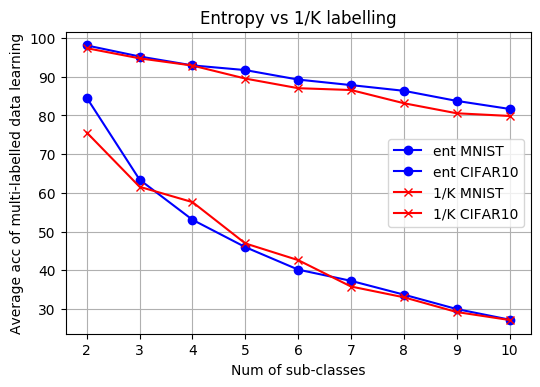

In [55]:
plt.figure(dpi = 100)
plt.title("Entropy vs 1/K labelling")
# ent
plt.plot([i for i in range(2, 11)], ent_results[0], color = "b", marker = "o", label = "ent MNIST")
#plt.plot([i for i in range(2, 11)], results_c10_ent, color = "g", marker = "o", label = "ent CIFAR10")
plt.plot([i for i in range(2, 11)], ent_results[1], color = "b", marker = "o", label = "ent CIFAR10")
#plt.plot([i for i in range(2, 11)], ent_results[2], color = "g", marker = "o", label = "ent CIFAR100")
# 1/K
plt.plot([i for i in range(2, 11)], oneKth_results[0], color = "r", marker = "x", label = "1/K MNIST")
plt.plot([i for i in range(2, 11)], oneKth_results[1], color = "r", marker = "x", label = "1/K CIFAR10")
#plt.plot([i for i in range(2, 11)], oneKth_results[2], color = "r", marker = "x", label = "1/K CIFAR100")

plt.xlabel("Num of sub-classes")
plt.ylabel("Average acc of multi-labelled data learning")	
plt.legend(loc = "center right")
plt.grid(True)

mizで計算したCIFAR10の10回平均の結果

In [45]:
results_c10_ent = [72.465     , 65.30666667, 54.9375    , 48.676     , 42.17      ,
       37.38428571, 32.67      , 29.44555556, 27.16      ]